# Machine Learning Classification of images using Local Binary Patterns (LBP) Feature Extractors with Linear SVM, Radial Basis Function (RBF) Support Vector Machines (SVM) and Random Forest Classifiers Seed 42

Repository: https://github.com/ZainK-hub/satbinclass

This notebook uses the versions listed below of the following packages:
* Python: 3.7.4
* PANDAS: 0.25.1
* Numpy: 1.17.2
* Matplotlib: 3.1.1
* Scikit-learn: 0.21.3
* Scipy: 1.3.1
* Tensorflow-GPU 1.14.0
* Tensorflow 1.14.0
* CUDA toolkit: 10.1.168
* CUDNN: 7.6.0
* Keras-GPU: 2.2.4
* Keras-preprocessing: 1.1.0

In [1]:
#Seed random generators to ensure reproducible results
from numpy.random import seed
seed(7)

import matplotlib.pyplot as plt
%matplotlib inline

import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from skimage.color import rgb2gray
from datetime import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils, to_categorical, plot_model

Using TensorFlow backend.
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anacon

## Introduction

This notebook contains the code for image classification using classical Machine Learning with Local Binary Patterns (LBP) combined with a Linear Support Vector Machine (SVM), Radial Basis Function (RBF) SVM and Random Forest (RF) Classifier using 2 fold cross-validation and 5 fold cross-validation.

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix, make_scorer
import pandas as pd

## Data preprocessing

The data is read in and preprocessed. Many Machine Learning algorithms may perform badly if the features do not appear to be standard normally distributed data i.e. a Gaussian with unit variance and mean of zero. Hence the features are standardised/normalised.

*StratifiedShuffleSplit* is used to ensure that the data is split and shuffled in such a way that the percentage of the categories of the data relative to the original dataset is maintained. A test dataset is made and separated from the dataset that will be used to train the model so as to not train on the data used to quantify the model performance since cross-validation is used.

(224, 224, 6, 1440)


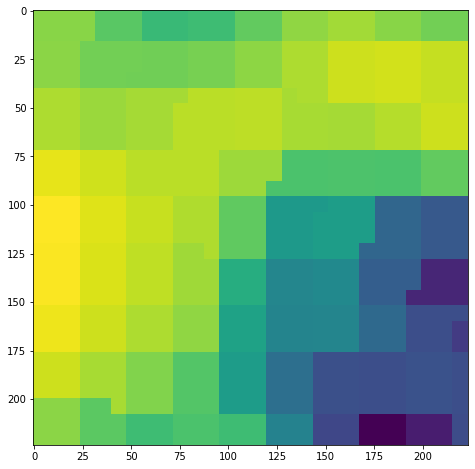

In [3]:
X = np.load('X.npy')
y = np.load('y.npy')
#One hot encoding
one_hot_y = to_categorical(y)
#y = one_hot_y
print(X.shape)

#img = ((np.clip(X[:,:,2,0],0,255))).astype('uint8')
img = X[:,:,2,0]
fig=plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

In [4]:
print(y.shape)
y = np.ravel(y)
y.shape

(1440, 1)


(1440,)

In [5]:
img_res = X.shape[0]
blobs = X.shape[3]
X = X.T
print(X.shape)

(1440, 6, 224, 224)


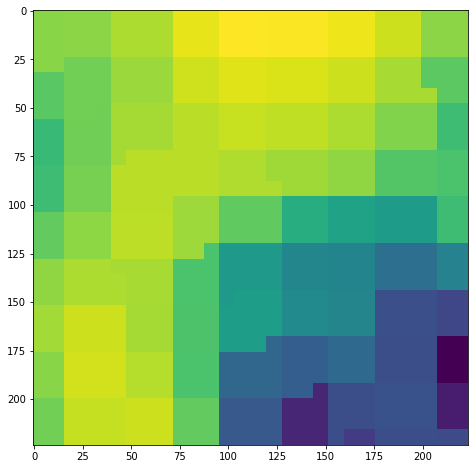

In [6]:
#img = ((np.clip(X[:,:,2,0],0,255))).astype('uint8')
img = X[0,2,:,:]
fig=plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

In [7]:
#Scale the disp, ph and coh bands to 0 to 255 so on same scale as RGB data
def scaleBandData(X):
    blobs = X.shape[0]
    bands = X.shape[1]
    print('band input shape', X.shape)
    X = X.T
    print('scale band data shape', X.shape)
    X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
    print('scale band data reshaped', X.shape)
    scaler = MinMaxScaler(feature_range=(0,255), copy=False)
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(blobs, bands, img_res, img_res)
    print('band output shape', X.shape)
    return X
#print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

#HoG descriptor does not need the band data to be scaled. This scaling is causing negative values to go to 0.
#X[:,0:3,:,:] = scaleBandData(X[:,0:3,:,:])
#print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

In [8]:
print(X.shape)
print('max, min', np.max(X), np.min(X))

(1440, 6, 224, 224)
max, min 255.0 -3.1403708457946777


In [9]:
X[0,:,:,2],

(array([[-1.68371052e-02, -1.68371052e-02, -1.68371052e-02, ...,
         -1.71945747e-02, -1.71945747e-02, -1.71945747e-02],
        [-2.46855569e+00, -2.46855569e+00, -2.46855569e+00, ...,
         -2.40978551e+00, -2.40978551e+00, -2.40978551e+00],
        [ 7.76160240e-01,  7.76160240e-01,  7.76160240e-01, ...,
          7.49362648e-01,  7.49362648e-01,  7.49362648e-01],
        [ 1.54000000e+02,  1.54000000e+02,  1.54000000e+02, ...,
          1.41000000e+02,  1.41000000e+02,  1.41000000e+02],
        [ 1.66000000e+02,  1.66000000e+02,  1.66000000e+02, ...,
          1.60000000e+02,  1.60000000e+02,  1.60000000e+02],
        [ 1.78000000e+02,  1.78000000e+02,  1.78000000e+02, ...,
          1.58000000e+02,  1.58000000e+02,  1.58000000e+02]]),)

(1440, 6, 224, 224)


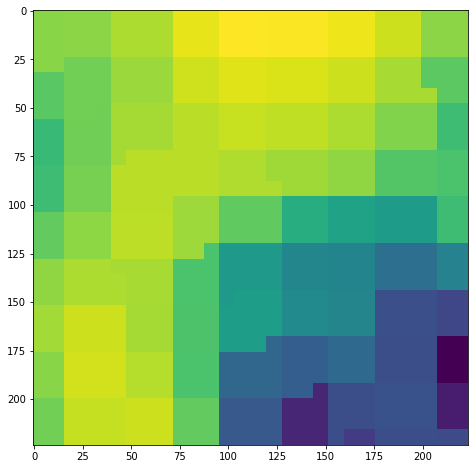

In [10]:
#Reshape to Keras desired shape
#X = X.reshape(X.shape[0], X.shape[2], X.shape[3], X.shape[1])
print(X.shape)

#Clip image to make it brighter, convert to 0 to 255
#img = ((np.clip(X[0,:,:,2],0,255))).astype('int')
img = X[0,2,:,:]
fig=plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

In [11]:
#Preprocessing of images, divide by 255, not for ResNet
#X[:,:,:,0:3]=X[:,:,:,0:3]/255
#X[:,:,:,3:6]=X[:,:,:,3:6]/255
#print('max, min', np.max(X), np.min(X))

## Classifier
The classifiers are implemented below.

In [12]:
#Setup single models
def singleModel(X_features_train_val, X_features_test, y_train, y_val, y_test, train_index, val_index, 
                single_model_name_str, results_arr, clf):
    
    print(single_model_name_str)
    X_train = X_features_train_val[train_index].copy()
    X_val = X_features_train_val[val_index].copy()
    X_test = X_features_test.copy()
    print('Train: ', X_train.shape, 'Validation:', X_val.shape, 'Test:', X_test.shape)         

    clf.fit(X_train, y_train)
    #preds = clf.predict_proba(X_val)  #For SVC the predict_proba uses Planck's thingy which can be wrong, 
    #set probability to true to use predict_proba
    #preds = clf.decision_function(X_val)
    #print(preds.shape, preds)
    #print('np.argmax(predsprobs, axis=1', np.argmax(preds, axis=1))
    preds = clf.predict(X_val)
    #print('preds rounded', preds.shape, np.round(preds,2))
    
    #val_acc = round(accuracy_score(y_val, np.round(np.argmax(preds, axis=1)))*100, 2)
    val_acc = round(accuracy_score(y_val, preds)*100, 2)

    print('Validation score of ' + single_model_name_str + ' model: ', val_acc, '%')
    
    print('Grid search has completed. \n Mean cross-validated score of the best estimator is:', clf.best_score_*100)
    print('The best parameters are: ', clf.best_params_, '\n')
    results_arr.append(clf.best_params_)
    
    results_arr.append(val_acc)      
    #test_preds = clf.decision_function(X_test)
    #test_preds = clf.predict_proba(X_test)
    #test_acc = round(accuracy_score(y_test.copy(), np.round(np.argmax(test_preds,axis=1)))*100, 2)
    test_preds = clf.predict(X_test)
    test_acc = round(accuracy_score(y_test.copy(), test_preds)*100, 2)
    print('Testing Accuracy on totally unseen data of ' + single_model_name_str + ' model: ', test_acc, '%')
    results_arr.append(test_acc)     
    #results_arr = evaluator(np.round(np.argmax(test_preds,axis=1)), y_test.copy(), results_arr)
    results_arr = evaluator(test_preds, y_test.copy(), results_arr)
    del X_train, X_val, X_test, y_train
    
    return results_arr


#Evaluate performance
def evaluator(test_preds, y_test, results_arr):
    f1_sco = round(f1_score(y_test, np.round(test_preds), average='macro'), 2)
    precision = round(precision_score(y_test, np.round(test_preds), average='macro'), 2)
    recall = round(recall_score(y_test, np.round(test_preds), average='macro'), 2)
    print('F1 score is: ', f1_sco)
    print('Recall score is: ', precision)
    print('Precision score is: ', recall)

    confu = confusion_matrix(y_test, test_preds)
    print('Confusion matrix: \n', confu)
    print('From the confusion matrix above there are ' + str(confu[0, 0]) + ' true negatives and ' + str(confu[0, 1]) 
          + ' false positives.') 
    print('There are ' + str(confu[1, 0]) + ' false negatives and ' + str(confu[1, 1]) + ' true positives. \n')
    performance = np.array((f1_sco, precision, recall, confu[0, 0], confu[0, 1], confu[1, 0], confu[1, 1]))
    for i in range(len(performance)):
        results_arr.append(performance[i])
    return results_arr
    
#Ensemble models
def ensembler(X_features_train_val, X_features_test):
    X_ensemble_features_train_val = combiner(X_features_train_val)
    del X_features_train_val
    X_ensemble_features_test = combiner(X_features_test)
    del X_features_test
    return X_ensemble_features_train_val, X_ensemble_features_test

def combiner(features):
    for i in range(len(features)):
        if i==0:
            combined_features=features[i]
        if i !=0:
            combined_features=np.hstack((combined_features,features[i][:,1:]))
    return combined_features

In [13]:
#Function to train model 
def trainModel(splits, y_train_val, y_test, 
                        X_locBinPat_features_train_val, X_locBinPat_features_test):

    sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)
    sss.get_n_splits(X_locBinPat_features_train_val, y_train_val)

    single_model_name = ['LBP SVM', 'LBP SVM RBF', 'LBP RF',]
    for i in range(len(single_model_name)):
        print('Model ' + str(i + 1) + ': ' + single_model_name[i])
    
    #Results column names
    col_names = ['Counter',]
    subnames = ['Best Param', 'Val Acc', 'Test Acc', 'F1 score', 'Precision', 'Recall', 'True Neg.', 'False Pos.', 'False Neg.', 'True Pos.',]
    for i in range(len(single_model_name)):
        for j in range(len(subnames)):
            col_names.append(single_model_name[i] + ' ' + subnames[j])
    
    #ensemble_names = ['HoG + LBP SVM RBF',]
    #for i in range(len(ensemble_names)):
    #    for j in range(len(subnames)):
    #        col_names.append(ensemble_names[i] + ' ' + subnames[j])

    results_data = pd.DataFrame(columns=col_names)
    results_arr = []

    #param_grid_logreg = dict(logisticregression__C=[0.001, 0.0005, 0.0001,])
    param_grid_svm = dict(svc__C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], svc__gamma =[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 
    svc__kernel=['rbf'])
    param_grid_lsvm = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0])
    param_grid_rf = dict(randomforestclassifier__n_estimators=[100, 150, 200, 250, 300],) 
                         
    #refit=True means at end it will train the best parameters on all the data and tune the hyperparameters to it
    #pipe_logreg = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=1000))
    #for SVC prob=True to use predict_proba but can have incorrect results rather set to false and use decision_function
    pipe_svm = make_pipeline(StandardScaler(), SVC())
    pipe_lsvm = make_pipeline(StandardScaler(), LinearSVC(max_iter=1000,))
    pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier())
    print('pipe', pipe_svm)
    clf = []
    
    clf.append(GridSearchCV(pipe_lsvm, param_grid=param_grid_lsvm, cv=sss, scoring=make_scorer(accuracy_score), refit=True))
    clf.append(GridSearchCV(pipe_svm, param_grid=param_grid_svm, cv=sss, scoring=make_scorer(accuracy_score), refit=True))
    #For LBP RF
    clf.append(GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=sss, scoring=make_scorer(accuracy_score), refit=True))
    #print(clf)
    
    counter = 0
    for train_index, val_index in sss.split(X_locBinPat_features_train_val, y_train_val):
        #Test to see if there any overlapped indices
        print('Overlap',set(train_index) & set (val_index))
        print('\n' + 'Counter: ', counter,)
        temp_time = time.time()
        results_arr.append(counter)
        print(datetime.now())
        print('Time: ', time.time()-temp_time)
        
        y_train = y_train_val[train_index].copy()
        y_val = y_train_val[val_index].copy()
        y_test = y_test.copy()
        
        # Model 1 LBP 
        results_arr = singleModel(X_locBinPat_features_train_val.copy(), X_locBinPat_features_test.copy(), y_train.copy(),
                            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[0], results_arr, clf[0])
        
        # Model 2 local Binary Pattern
        results_arr = singleModel(X_locBinPat_features_train_val.copy(), X_locBinPat_features_test.copy(), y_train.copy(), 
                            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[1], results_arr, clf[1])
        
        # Model 3 local Binary Pattern
        results_arr = singleModel(X_locBinPat_features_train_val.copy(), X_locBinPat_features_test.copy(), y_train.copy(),
                        y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[2], results_arr, clf[2])        
        
        #Append to data frame    
        temp_df2 = pd.DataFrame([results_arr], columns=col_names) 
        results_data = results_data.append(temp_df2, ignore_index=True, sort=False)
        print('results_data \n\n', results_data)
        results_arr.clear()
            
        #clear_session()
        counter = counter + 1
        del y_train, y_val, 
        
    print('10-fold cross validation has completed. \n Mean scores are :')
    print(results_data.mean(axis=0))
    results_copy  = results_data.copy()
    temp_df2 = pd.DataFrame(results_data.mean(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.var(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.std(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)

    return results_data

In [14]:
def histoOfOrientedGRadients(img, multichannel):
    #plt.imshow(img)
    #plt.savefig('\model\\' +'g.png')
    #Need to resize to ratio 1:2 for HoG Descriptor
    img = resize(img, (224, 112))
    fd, hog_img = hog(img, orientations=9, pixels_per_cell=(8,8), 
            cells_per_block=(2,2), visualize=True, multichannel=multichannel)
    fd = fd/fd.sum()
    hog_img = hog_img/hog_img.sum()
    #plt.imshow(hog_img)
    #plt.savefig('\model\\' +'hog.png') 
    return fd

def locBinaryPattern(img):
    img_gray = rgb2gray(img)

    #plt.imshow(img_gray)
    #plt.savefig('\model\\' +'orig.png') 
    
    rad = 3
    no_points = 8*rad
    lbp = local_binary_pattern(img_gray, no_points, rad, method='uniform')
    histo, bins = np.histogram(lbp)
    histo = histo/np.sum(histo)
    #plt.imshow(lbp)
    #plt.savefig('\model\\' +'lbp.png') 
    return histo

#Extract Features
def featureExtractor(model, X_band, X_rgb):
    #float32 gives faster speed and negligible loss of precision
    X_band = X_band.astype('float32')
    X_rgb = X_rgb.astype('float32')
    
    #HoG
    if model=='HoG':
        #HoG features are 12636
        hog_start = time.time()
        print('Histo of Oriented Gradients Starting: ', hog_start, '\n', datetime.now())
        features_1 = np.zeros((X_band.shape[0],12636), dtype='float32')
        features_2 = np.zeros((X_band.shape[0],12636), dtype='float32')
        features_3 = np.zeros((X_band.shape[0],12636), dtype='float32')
        features_4 = np.zeros((X_rgb.shape[0],12636), dtype='float32')
        for i in range(X_band.shape[0]):
            features_1[i,:] = histoOfOrientedGRadients(X_band[i,0,:,:], False) #Disp, phase and coherence 
            features_2[i,:] = histoOfOrientedGRadients(X_band[i,1,:,:], False) #Disp, phase and coherence
            features_3[i,:] = histoOfOrientedGRadients(X_band[i,2,:,:], False) #Disp, phase and coherence
        print('Histo of Oriented Gradients features_1 shape \n', features_1.shape)
        print('Histo of Oriented Gradients features_2 shape \n', features_2.shape)
        print('Histo of Oriented Gradients features_3 shape \n', features_3.shape)
        for i in range(X_rgb.shape[0]):
            features_4[i,:] = histoOfOrientedGRadients(X_rgb[i,:,:,:], True) #RGB 3 band image
        print('Histo of Oriented Gradients features_4 shape \n', features_4.shape)
        hog_end = hog_start - time.time()
        print('Histo of Oriented Gradients features end: ', hog_end, '\n', datetime.now() )
    elif model=='LBP':
        lbp_start = datetime.now()
        print('LBP Feature Extraction Start ', lbp_start)
        #LBP features are 26
        features_1 = np.zeros((X_band.shape[0],10), dtype='float32')
        features_2 = np.zeros((X_band.shape[0],10), dtype='float32')
        features_3 = np.zeros((X_band.shape[0],10), dtype='float32')
        features_4 = np.zeros((X_rgb.shape[0],10), dtype='float32')        

        for i in range(X_band.shape[0]):
            features_1[i,:] = locBinaryPattern(X_band[i,0,:,:]) #Disp, phase and coherence
            features_2[i,:] = locBinaryPattern(X_band[i,1,:,:]) #Disp, phase and coherence
            features_3[i,:] = locBinaryPattern(X_band[i,2,:,:]) #Disp, phase and coherence
                
        for i in range(X_rgb.shape[0]):
            features_4[i,:] = locBinaryPattern(X_rgb[i,:,:,:]) #RGB 3 band image
        print('LBP features_1 shape \n', features_1.shape)
        print('LBP features_2 shape \n', features_2.shape)
        print('LBP features_3 shape \n', features_3.shape)
        print('LBP features_4 shape \n', features_4.shape)
        
        print('LBP Feature Extraction end: ', datetime.now())
    del X_band, X_rgb
    
    #For HoG you would get a 1D vector so below might not be necessary
    X_feat = np.hstack((features_1,features_2, features_3, features_4))
    del features_1, features_2, features_3, features_4
    return X_feat

In [15]:
def initiate(folds, X, y):
    
    print(datetime.now())
    start = time.time()
    print('X, y shapes: ', X.shape, y.shape)

    #Split the data to get a hold out test set
    sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    num_splits = sss_initial.get_n_splits(X, y)

    for train_val_index, test_index in sss_initial.split(X, y):
        #print('Train-Validation: ', train_val_index, 'Testing', test_index)
        print('Train-Test Split: ', datetime.now())

        X_train_val = X[train_val_index].copy()
        y_train_val = y[train_val_index].copy()

        X_test = X[test_index].copy()
        y_test = y[test_index].copy()

        del X, y
        X_band_train_val = X_train_val[:,0:3,:,:].copy()
        X_rgb_train_val = X_train_val[:,3:6,:,].copy()
        X_band_test = X_test[:,0:3,:,:].copy()
        X_rgb_test = X_test[:,3:6,:,:].copy()

        #Image preprocessing EfficientNet B4
        image_size = 224

        del X_train_val, X_test

        model_str = 'LBP'
        print("\n Generating Local Binary Pattern features \n")
        X_locBinPat_features_train_val = featureExtractor(model_str, X_band_train_val.copy(), X_rgb_train_val.copy())
        X_locBinPat_features_test = featureExtractor(model_str, X_band_test.copy(), X_rgb_test.copy())
        #clear_session()

        del X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test

        results = trainModel(folds, y_train_val, y_test, 
                            X_locBinPat_features_train_val, X_locBinPat_features_test)

        del X_locBinPat_features_train_val, X_locBinPat_features_test, y_train_val, y_test 

    #Save results to CSV
    results.to_csv('./model/' + 'ML_LBP_' + str(folds) + '_fold_SVM_RBF_SVM_RF_Results.csv', sep=',', index=False)

    end = time.time()
    elapsed = end - start
    print('Total running time (h): %.2f hours' % (elapsed/3600.0))
    print(datetime.now())
    
initiate(5, X.copy(), y.copy())
initiate(2, X.copy(), y.copy())

2021-08-06 21:17:25.793750
X, y shapes:  (1440, 6, 224, 224) (1440,)
Train-Test Split:  2021-08-06 21:17:25.795520

 Generating Local Binary Pattern features 

LBP Feature Extraction Start  2021-08-06 21:18:04.660206
LBP features_1 shape 
 (1152, 10)
LBP features_2 shape 
 (1152, 10)
LBP features_3 shape 
 (1152, 10)
LBP features_4 shape 
 (1152, 10)
LBP Feature Extraction end:  2021-08-06 21:19:00.445478
LBP Feature Extraction Start  2021-08-06 21:19:00.650632
LBP features_1 shape 
 (288, 10)
LBP features_2 shape 
 (288, 10)
LBP features_3 shape 
 (288, 10)
LBP features_4 shape 
 (288, 10)
LBP Feature Extraction end:  2021-08-06 21:19:12.857085
Model 1: LBP SVM
Model 2: LBP SVM RBF
Model 3: LBP RF
pipe Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degr

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

Validation score of LBP SVM model:  70.13 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 67.24324324324324
The best parameters are:  {'linearsvc__C': 10.0} 

Testing Accuracy on totally unseen data of LBP SVM model:  68.75 %
F1 score is:  0.69
Recall score is:  0.69
Precision score is:  0.69
Confusion matrix: 
 [[ 98  46]
 [ 44 100]]
From the confusion matrix above there are 98 true negatives and 46 false positives.
There are 44 false negatives and 100 true positives. 

LBP SVM RBF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP SVM RBF model:  71.0 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 68.64864864864865
The best parameters are:  {'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 

Testing Accuracy on totally unseen data of LBP SVM RBF model:  69.79 %
F1 score is:  0.7
Recall score is:  0.7
Precision score is:  0.7
Confusion matrix: 
 [[ 97  47]
 [ 40 104]]
From t

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

Validation score of LBP SVM model:  68.83 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 71.13513513513513
The best parameters are:  {'linearsvc__C': 10.0} 

Testing Accuracy on totally unseen data of LBP SVM model:  67.36 %
F1 score is:  0.67
Recall score is:  0.67
Precision score is:  0.67
Confusion matrix: 
 [[97 47]
 [47 97]]
From the confusion matrix above there are 97 true negatives and 47 false positives.
There are 47 false negatives and 97 true positives. 

LBP SVM RBF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP SVM RBF model:  72.73 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 72.75675675675676
The best parameters are:  {'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 

Testing Accuracy on totally unseen data of LBP SVM RBF model:  66.67 %
F1 score is:  0.67
Recall score is:  0.67
Precision score is:  0.67
Confusion matrix: 
 [[ 90  54]
 [ 42 102]]
From th

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

Validation score of LBP SVM model:  65.8 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 72.64864864864865
The best parameters are:  {'linearsvc__C': 10.0} 

Testing Accuracy on totally unseen data of LBP SVM model:  66.67 %
F1 score is:  0.67
Recall score is:  0.67
Precision score is:  0.67
Confusion matrix: 
 [[ 89  55]
 [ 41 103]]
From the confusion matrix above there are 89 true negatives and 55 false positives.
There are 41 false negatives and 103 true positives. 

LBP SVM RBF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP SVM RBF model:  71.43 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 72.97297297297297
The best parameters are:  {'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 

Testing Accuracy on totally unseen data of LBP SVM RBF model:  68.06 %
F1 score is:  0.68
Recall score is:  0.68
Precision score is:  0.68
Confusion matrix: 
 [[ 91  53]
 [ 39 105]]
Fro

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

Validation score of LBP SVM model:  64.5 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 68.54054054054053
The best parameters are:  {'linearsvc__C': 0.01} 

Testing Accuracy on totally unseen data of LBP SVM model:  68.06 %
F1 score is:  0.68
Recall score is:  0.68
Precision score is:  0.68
Confusion matrix: 
 [[ 95  49]
 [ 43 101]]
From the confusion matrix above there are 95 true negatives and 49 false positives.
There are 43 false negatives and 101 true positives. 

LBP SVM RBF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP SVM RBF model:  65.37 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 69.51351351351352
The best parameters are:  {'svc__C': 1.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 

Testing Accuracy on totally unseen data of LBP SVM RBF model:  65.97 %
F1 score is:  0.66
Recall score is:  0.66
Precision score is:  0.66
Confusion matrix: 
 [[ 86  58]
 [ 40 104]]
From 

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

Validation score of LBP SVM model:  65.37 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 67.67567567567568
The best parameters are:  {'linearsvc__C': 0.001} 

Testing Accuracy on totally unseen data of LBP SVM model:  68.75 %
F1 score is:  0.69
Recall score is:  0.69
Precision score is:  0.69
Confusion matrix: 
 [[ 98  46]
 [ 44 100]]
From the confusion matrix above there are 98 true negatives and 46 false positives.
There are 44 false negatives and 100 true positives. 

LBP SVM RBF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP SVM RBF model:  69.7 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 70.05405405405405
The best parameters are:  {'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 

Testing Accuracy on totally unseen data of LBP SVM RBF model:  66.67 %
F1 score is:  0.67
Recall score is:  0.67
Precision score is:  0.67
Confusion matrix: 
 [[ 90  54]
 [ 42 102]]
Fr

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

Validation score of LBP SVM model:  70.13 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 64.32432432432432
The best parameters are:  {'linearsvc__C': 10.0} 

Testing Accuracy on totally unseen data of LBP SVM model:  68.75 %
F1 score is:  0.69
Recall score is:  0.69
Precision score is:  0.69
Confusion matrix: 
 [[ 95  49]
 [ 41 103]]
From the confusion matrix above there are 95 true negatives and 49 false positives.
There are 41 false negatives and 103 true positives. 

LBP SVM RBF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP SVM RBF model:  70.56 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 66.21621621621621
The best parameters are:  {'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'} 

Testing Accuracy on totally unseen data of LBP SVM RBF model:  69.1 %
F1 score is:  0.69
Recall score is:  0.69
Precision score is:  0.69
Confusion matrix: 
 [[ 97  47]
 [ 42 102]]
From t

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarni

Validation score of LBP SVM model:  69.7 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 72.16216216216216
The best parameters are:  {'linearsvc__C': 0.1} 

Testing Accuracy on totally unseen data of LBP SVM model:  68.4 %
F1 score is:  0.68
Recall score is:  0.68
Precision score is:  0.68
Confusion matrix: 
 [[ 95  49]
 [ 42 102]]
From the confusion matrix above there are 95 true negatives and 49 false positives.
There are 42 false negatives and 102 true positives. 

LBP SVM RBF
Train:  (921, 40) Validation: (231, 40) Test: (288, 40)
Validation score of LBP SVM RBF model:  68.4 %
Grid search has completed. 
 Mean cross-validated score of the best estimator is: 74.86486486486487
The best parameters are:  {'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'} 

Testing Accuracy on totally unseen data of LBP SVM RBF model:  67.36 %
F1 score is:  0.67
Recall score is:  0.68
Precision score is:  0.67
Confusion matrix: 
 [[ 88  56]
 [ 38 106]]
From the 

## Note
- **The results for seed 42 are contained in the *'ML_LBP_5_fold_SVM_RBF_SVM_RF_Results.csv'* and the *''ML_LBP_2_fold_SVM_RBF_SVM_RF_Results.csv''* files in the *model* folder.**